# Part 3: Train a diffusion model for image generation

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/digits_diffusion_model.ipynb)

This tutorial guides you through developing and training a simple diffusion model using the [U-Net architecture](https://en.wikipedia.org/wiki/U-Net) for image generation using JAX, [Flax NNX](http://flax.readthedocs.io) and [Optax](http://optax.readthedocs.io). This builds upon the previous tutorial, [Variational autoencoder (VAE) and debugging in JAX](https://jax-ai-stack.readthedocs.io/en/latest/digits_vae.html), which focus on training a simpler generative model called VAE.

In this tutorial, you'll learn how to:

- Load and preprocess the dataset
- Define the diffusion model with Flax
- Create the loss and training functions
- Train the model (with Google Colab’s Cloud TPU v2)
- Visualize and track the model’s progress

If you are new to JAX for AI, check out the [introductory tutorial](https://jax-ai-stack.readthedocs.io/en/latest/neural_net_basics.html), which covers neural network building with Flax, Optax and JAX.

## Setup

JAX for AI (the stack) installation is covered [here](https://docs.jaxstack.ai/en/latest/install.html). And JAX (the library) installation is covered in [this guide](https://jax.readthedocs.io/en/latest/installation.html) on the JAX documentation site.

Start with importing JAX, JAX NumPy, Flax NNX, Optax, matplotlib and scikit-learn:

In [ ]:
import jax
import optax
from flax import nnx
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from typing import Tuple, Callable, List, Optional
from sklearn.model_selection import train_test_split

**Note:** If you are using [Google Colab](https://colab.research.google.com/), select the free Google Cloud TPU v2 as the hardware accelerator.

Check the available JAX devices, or [`jax.Device`s](https://jax.readthedocs.io/en/latest/_autosummary/jax.Device.html), with [`jax.devices()`](https://jax.readthedocs.io/en/latest/_autosummary/jax.devices.html). The output of the cell below will show a list of 8 (eight) devices:

In [ ]:
# Check the available JAX devices.
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

## Loading and preprocessing the data

We'll use the small, self-contained [scikit-learn `digits` dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) for ease of experimentation to demonstrate diffusion model training. For simplicity, we'll focus on generating only the digit '1' (one).

This involves several steps, such as:

1. Loading the dataset
2. Filtering the images of '1' (one)
3. Normalizing pixel values
4. Converting the data into `jax.Array`s
5. Reshaping the data, and splitting it into training and test sets

Training set size: 172
Test set size: 10


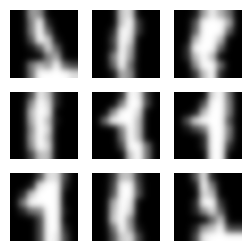

In [ ]:
# Load and preprocess the `digits` dataset.
digits = load_digits()
# Filter for digit '1' (one) images.
images = digits.images[digits.target == 1]
# Normalize pixel values into floating-point arrays in the `[0, 1]` interval.
images = images / 16.0
# Convert to `jax.Array`s.
images = jnp.asarray(images)
# Reshape to `(num_images, height, width, channels)` for convolutional layers.
images = images.reshape(-1, 8, 8, 1)

# Split the dataset into training and test sets (5% for testing).
images_train, images_test = train_test_split(images, test_size=0.05, random_state=42)
print(f"Training set size: {images_train.shape[0]}")
print(f"Test set size: {images_test.shape[0]}")

# Visualize sample images.
fig, axes = plt.subplots(3, 3, figsize=(3, 3))
for i, ax in enumerate(axes.flat):
    if i < len(images_train):
        ax.imshow(images_train[i, ..., 0], cmap='gray', interpolation='gaussian')
        ax.axis('off')
plt.show()

## Defining the diffusion model with Flax

In this section, we’ll develop various parts of the [diffusion model](https://en.wikipedia.org/wiki/Diffusion_model) and then put them all together.

### The U-Net architecture

For this example, we’ll use the [U-Net architecture](https://en.wikipedia.org/wiki/U-Net), a convolutional neural network architecture, as the backbone of the diffusion model. The U-Net consists of the following:

- An [encoder](https://en.wikipedia.org/wiki/Autoencoder) path that [downsamples](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)) the input image, extracting features.
- A bridge with a (self-)[attention mechanism](https://en.wikipedia.org/wiki/Attention_(machine_learning) that connects the encoder with the decoder.
- A [decoder](https://en.wikipedia.org/wiki/Autoencoder) path that [upsamples](https://en.wikipedia.org/wiki/Upsampling) the feature representations learned by the encoder, reconstructing the output image.
- [Skip connections](https://en.wikipedia.org/wiki/Residual_neural_network#Residual_connection) between the encoder and the decoder.

Let's define a class called `UNet` by subclassing [`flax.nnx.Module`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/module.html#flax.nnx.Module) and using, among other things, [`flax.nnx.Linear`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/nn/linear.html#flax.nnx.Linear) (linear or dense layers for time embedding and time projection layers, as well as the self-attention layers), [`flax.nnx.LayerNorm`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/nn/normalization.html#flax.nnx.LayerNorm) (layer normalization), and [`flax.nnx.Conv`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/nn/linear.html#flax.nnx.Conv) (convolution layers for the output layer).

In [ ]:
class UNet(nnx.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 features: int,
                 time_emb_dim: int = 128,
                 *,
                 rngs: nnx.Rngs):
        """
        Initialize the U-Net architecture with time embedding.
        """
        self.features = features

        # Time embedding layers for diffusion timestep conditioning.
        self.time_mlp_1 = nnx.Linear(in_features=time_emb_dim, out_features=time_emb_dim, rngs=rngs)
        self.time_mlp_2 = nnx.Linear(in_features=time_emb_dim, out_features=time_emb_dim, rngs=rngs)

        # Time projection layers for different scales.
        self.time_proj1 = nnx.Linear(in_features=time_emb_dim, out_features=features, rngs=rngs)
        self.time_proj2 = nnx.Linear(in_features=time_emb_dim, out_features=features * 2, rngs=rngs)
        self.time_proj3 = nnx.Linear(in_features=time_emb_dim, out_features=features * 4, rngs=rngs)
        self.time_proj4 = nnx.Linear(in_features=time_emb_dim, out_features=features * 8, rngs=rngs)

        # The encoder path.
        self.down_conv1 = self._create_residual_block(in_channels, features, rngs)
        self.down_conv2 = self._create_residual_block(features, features * 2, rngs)
        self.down_conv3 = self._create_residual_block(features * 2, features * 4, rngs)
        self.down_conv4 = self._create_residual_block(features * 4, features * 8, rngs)

        # Multi-head self-attention blocks.
        self.attention1 = self._create_attention_block(features * 4, rngs)
        self.attention2 = self._create_attention_block(features * 8, rngs)

        # The bridge connecting the encoder and the decoder.
        self.bridge_down = self._create_residual_block(features * 8, features * 16, rngs)
        self.bridge_attention = self._create_attention_block(features * 16, rngs)
        self.bridge_up = self._create_residual_block(features * 16, features * 16, rngs)

        # Decoder path with skip connections.
        self.up_conv4 = self._create_residual_block(features * 24, features * 8, rngs)
        self.up_conv3 = self._create_residual_block(features * 12, features * 4, rngs)
        self.up_conv2 = self._create_residual_block(features * 6, features * 2, rngs)
        self.up_conv1 = self._create_residual_block(features * 3, features, rngs)

        # Output layers.
        self.final_norm = nnx.LayerNorm(features, rngs=rngs)
        self.final_conv = nnx.Conv(in_features=features,
                                 out_features=out_channels,
                                 kernel_size=(3, 3),
                                 strides=(1, 1),
                                 padding=((1, 1), (1, 1)),
                                 rngs=rngs)

    def _create_attention_block(self, channels: int, rngs: nnx.Rngs) -> Callable:
        """Creates a self-attention block with learned query, key, value projections.

        Args:
            channels (int): The number of channels in the input feature maps.
            rngs (flax.nnx.Rngs): A set of named `flax.nnx.RngStream` objects that generate a stream of JAX pseudo-random number generator (PRNG) keys.

        Returns:
            Callable: A function representing a forward pass through the attention block.

        """
        query_proj = nnx.Linear(in_features=channels, out_features=channels, rngs=rngs)
        key_proj = nnx.Linear(in_features=channels, out_features=channels, rngs=rngs)
        value_proj = nnx.Linear(in_features=channels, out_features=channels, rngs=rngs)

        def forward(x: jax.Array) -> jax.Array:
            """Applies self-attention to the input.

            Args:
                x (jax.Array): The input tensor with the shape `[batch, height, width, channels]` (or `B, H, W, C`).

            Returns:
                jax.Array: The output tensor after applying self-attention.
            """

            # Shape: batch, height, width, channels.
            B, H, W, C = x.shape
            scale = jnp.sqrt(C).astype(x.dtype)

            # Project the input into query, key, value projections.
            q = query_proj(x)
            k = key_proj(x)
            v = value_proj(x)

            # Reshape for the attention computation.
            q = q.reshape(B, H * W, C)
            k = k.reshape(B, H * W, C)
            v = v.reshape(B, H * W, C)

            # Compute the scaled dot-product attention.
            attention = jnp.einsum('bic,bjc->bij', q, k) / scale  # Scaled dot-product.
            attention = jax.nn.softmax(attention, axis=-1)  # Softmax.

            # The output tensor.
            out = jnp.einsum('bij,bjc->bic', attention, v)
            out = out.reshape(B, H, W, C)

            return x + out  # A ResNet-style residual connection.

        return forward

    def _create_residual_block(self,
                              in_channels: int,
                              out_channels: int,
                              rngs: nnx.Rngs) -> Callable:
        """Creates a residual block with two convolutions and normalization.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            rngs (flax.nnx.Rngs): A set of named `flax.nnx.RngStream` objects that generate a stream of JAX PRNG keys.

        Returns:
            Callable: A function that represents the forward pass through the residual block.
        """

        # Convolutional layers with layer normalization.
        conv1 = nnx.Conv(in_features=in_channels,
                        out_features=out_channels,
                        kernel_size=(3, 3),
                        strides=(1, 1),
                        padding=((1, 1), (1, 1)),
                        rngs=rngs)
        norm1 = nnx.LayerNorm(out_channels, rngs=rngs)
        conv2 = nnx.Conv(in_features=out_channels,
                        out_features=out_channels,
                        kernel_size=(3, 3),
                        strides=(1, 1),
                        padding=((1, 1), (1, 1)),
                        rngs=rngs)
        norm2 = nnx.LayerNorm(out_channels, rngs=rngs)

        # Projection shortcut if dimensions change.
        shortcut = nnx.Conv(in_features=in_channels,
                            out_features=out_channels,
                            kernel_size=(1, 1),
                            strides=(1, 1),
                            rngs=rngs)

        # The forward pass through the residual block.
        def forward(x: jax.Array) -> jax.Array:
            identity = shortcut(x)

            x = conv1(x)
            x = norm1(x)
            x = nnx.gelu(x)

            x = conv2(x)
            x = norm2(x)
            x = nnx.gelu(x)

            return x + identity

        return forward

    def _pos_encoding(self, t: jax.Array, dim: int) -> jax.Array:
        """Applies sinusoidal positional encoding for time embedding.

        Args:
            t (jax.Array): The time embedding, representing the timestep.
            dim (int): The dimension of the output positional encoding.

        Returns:
            jax.Array: The sinusoidal positional embedding per timestep.

        """
        # Calculate half the embedding dimension.
        half_dim = dim // 2
        # Compute the logarithmic scaling factor for sinusoidal frequencies.
        emb = jnp.log(10000.0) / (half_dim - 1)
        # Generate a range of sinusoidal frequencies.
        emb = jnp.exp(jnp.arange(half_dim) * -emb)
        # Create the positional encoding by multiplying time embeddings with.
        emb = t[:, None] * emb[None, :]
        # Concatenate sine and cosine components for richer representation.
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=1)
        return emb

    def _downsample(self, x: jax.Array) -> jax.Array:
        """Downsamples the input feature map with max pooling."""
        return nnx.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding='SAME')

    def _upsample(self, x: jax.Array, target_size: int) -> jax.Array:
        """Upsamples the input feature map using nearest neighbor interpolation."""
        return jax.image.resize(x,
                              (x.shape[0], target_size, target_size, x.shape[3]),
                              method='nearest')

    def __call__(self, x: jax.Array, t: jax.Array) -> jax.Array:
        """Perform the forward pass through the U-Net using time embeddings."""

        # Time embedding and projection.
        t_emb = self._pos_encoding(t, 128) # Sinusoidal positional encoding for time.
        t_emb = self.time_mlp_1(t_emb) # Project and activate the time embedding
        t_emb = nnx.gelu(t_emb) # Activation function: `flax.nnx.gelu` (GeLU).
        t_emb = self.time_mlp_2(t_emb)

        # Project time embeddings for each scale.
        # Project to the correct dimensions for each encoder block.
        t_emb1 = self.time_proj1(t_emb)[:, None, None, :]
        t_emb2 = self.time_proj2(t_emb)[:, None, None, :]
        t_emb3 = self.time_proj3(t_emb)[:, None, None, :]
        t_emb4 = self.time_proj4(t_emb)[:, None, None, :]

        # The encoder path with time injection.
        d1 = self.down_conv1(x)
        t_emb1 = jnp.broadcast_to(t_emb1, d1.shape) # Broadcast the time embedding to match feature map shape.
        d1 = d1 + t_emb1 # Add the time embedding to the feature map.

        d2 = self.down_conv2(self._downsample(d1))
        t_emb2 = jnp.broadcast_to(t_emb2, d2.shape)
        d2 = d2 + t_emb2

        d3 = self.down_conv3(self._downsample(d2))
        d3 = self.attention1(d3) # Apply self-attention.
        t_emb3 = jnp.broadcast_to(t_emb3, d3.shape)
        d3 = d3 + t_emb3

        d4 = self.down_conv4(self._downsample(d3))
        d4 = self.attention2(d4)
        t_emb4 = jnp.broadcast_to(t_emb4, d4.shape)
        d4 = d4 + t_emb4

        # The bridge.
        b = self._downsample(d4)
        b = self.bridge_down(b)
        b = self.bridge_attention(b)
        b = self.bridge_up(b)

        # The decoder path with skip connections.
        u4 = self.up_conv4(jnp.concatenate([self._upsample(b, d4.shape[1]), d4], axis=-1))
        u3 = self.up_conv3(jnp.concatenate([self._upsample(u4, d3.shape[1]), d3], axis=-1))
        u2 = self.up_conv2(jnp.concatenate([self._upsample(u3, d2.shape[1]), d2], axis=-1))
        u1 = self.up_conv1(jnp.concatenate([self._upsample(u2, d1.shape[1]), d1], axis=-1))

        # Final layers.
        x = self.final_norm(u1)
        x = nnx.gelu(x)
        return self.final_conv(x)

### Defining the diffusion model

Here, we will define the diffusion model that encapsulates the previously components, such as the `UNet` class, and include all the layers needed to perform the diffusion operations. The `DiffusionModel` class implements the diffusion process with:

- Forward diffusion (adding noise)
- Reverse diffusion (denoising)
- Custom noise scheduling

In [ ]:
class DiffusionModel:
    def __init__(self,
                 model: UNet,
                 num_steps: int,
                 beta_start: float,
                 beta_end: float):
        """Initialize diffusion process parameters.

        Args:
            model (UNet): The U-Net model for image generation.
            num_steps (int): The number of diffusion steps in the process.
            beta_start: The starting value for beta, controlling the noise level.
            beta_end: The end value for beta.
        """
        self.model = model
        self.num_steps = num_steps

        # Noise schedule parameters.
        self.beta = self._cosine_beta_schedule(num_steps, beta_start, beta_end)
        self.alpha = 1 - self.beta
        self.alpha_cumulative = jnp.cumprod(self.alpha)

        self.sqrt_alpha_cumulative = jnp.sqrt(self.alpha_cumulative)
        self.sqrt_one_minus_alpha_cumulative = jnp.sqrt(1 - self.alpha_cumulative)
        self.sqrt_recip_alpha = jnp.sqrt(1 / self.alpha)

        self.posterior_variance = self.beta * (1 - self.alpha_cumulative) / (1 - self.alpha_cumulative + 1e-7)

    def _cosine_beta_schedule(self,
                            num_steps: int,
                            beta_start: float,
                            beta_end: float) -> jax.Array:
        """Cosine schedule for noise levels."""
        steps = jnp.linspace(0, num_steps, num_steps + 1)
        x = steps / num_steps
        alphas = jnp.cos(((x + 0.008) / 1.008) * jnp.pi * 0.5) ** 2
        alphas = alphas / alphas[0]
        betas = 1 - (alphas[1:] / alphas[:-1])
        betas = jnp.clip(betas, beta_start, beta_end)
        return jnp.concatenate([betas[0:1], betas])

    def forward(self,
                x: jax.Array,
                t: jax.Array,
                key: jax.Array) -> Tuple[jax.Array, jax.Array]:
        """Forward diffusion process - adds noise according to schedule.

        Args:
            x (jax.Array): The input image.
            t (jax.Array): The timestep(s) at which the noise is added.
            key (jax.Array): A JAX PRNG key for generating random noise.

        Returns:
            Tuple[jax.Array, jax.Array]
        """
        noise = jax.random.normal(key, x.shape)
        noisy_x = (
            jnp.sqrt(self.alpha_cumulative[t])[:, None, None, None] * x +
            jnp.sqrt(1 - self.alpha_cumulative[t])[:, None, None, None] * noise
        )
        return noisy_x, noise

    def reverse(self, x: jax.Array, key: jax.Array) -> jax.Array:
        """Performs the reverse diffusion process, denoising the input image gradually.

        Args:
            x (jax.Array): The noise image batch per timestep.
            key (jax.Array): A JAX PRNG key for the random noise.
        """
        x_t = x
        for t in reversed(range(self.num_steps)):
            t_batch = jnp.array([t] * x.shape[0])
            predicted = self.model(x_t, t_batch) # Predicted noise using the U-Net.

            key, subkey = jax.random.split(key) # Split the JAX PRNG key.
            noise = jax.random.normal(subkey, x_t.shape) if t > 0 else 0 # Sample the noise for the current timestep.

            # The denoising step.
            x_t = (1 / jnp.sqrt(self.alpha[t])) * (
                x_t - ((1 - self.alpha[t]) / jnp.sqrt(1 - self.alpha_cumulative[t])) * predicted
            ) + jnp.sqrt(self.beta[t]) * noise

        return x_t # The final denoised image.

## Defining the loss function and training step

In this section, we’ll define the components for training our diffusion model, including:

- The loss function (`loss_fn()`), which incorporates [SNR weighting](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) and a gradient penalty; and
- The training step (`train_step()`) with [gradient clipping](https://arxiv.org/pdf/1905.11881) for stability.

In [ ]:
def loss_fn(model: UNet,
           images: jax.Array,
           t: jax.Array,
           noise: jax.Array,
           sqrt_alpha_cumulative: jax.Array,
           sqrt_one_minus_alpha_cumulative: jax.Array) -> jax.Array:
    """Computes the diffusion loss function with SNR weighting and adaptive noise scaling.

    Args:
        model(UNet): The U-Net model for image generation.
        images (jax.Array): A batch of images used for training.
        t (jax.Array): The timestep(s) at which the noise is added to each image.
        noise (jax.Array): The noise added to the images.
        sqrt_alpha_cumulative (jax.Array): Square root of cumulative alpha values.
        sqrt_one_minus_alpha_cumulative (jax.Array): Square root of (1 - cumulative alpha values).

        Returns:
            jax.Array: The total loss value.
    """

    # Generate noisy images.
    noisy_images = (
        sqrt_alpha_cumulative[t][:, None, None, None] * images +
        sqrt_one_minus_alpha_cumulative[t][:, None, None, None] * noise
    )

    # Predict the noise using the U-Net.
    predicted = model(noisy_images, t)

    # Compute the SNR-weighted loss.
    snr = (sqrt_alpha_cumulative[t] / sqrt_one_minus_alpha_cumulative[t])[:, None, None, None]
    loss_weights = snr / (1 + snr)

    squared_error = (noise - predicted) ** 2
    main_loss = jnp.mean(loss_weights * squared_error)

    # Perform gradient penalty (regularization) with a reduced coefficient.
    grad = jax.grad(lambda x: model(x, t).mean())(noisy_images)
    grad_penalty = 0.02 * (jnp.square(grad).mean())

    # The total loss.
    return main_loss + grad_penalty

# Flax NNX JIT-compilation for performance (`flax.nnx.jit`).
@nnx.jit
def train_step(model: UNet,
               optimizer: nnx.Optimizer,
               images: jax.Array,
               t: jax.Array,
               noise: jax.Array,
               sqrt_alpha_cumulative: jax.Array,
               sqrt_one_minus_alpha_cumulative: jax.Array) -> jax.Array:
    """Performs a single training step with gradient clipping.

    Args:
        model(UNet): The U-Net model for image generation that is being trained.
        optimizer (flax.nnx.Optimizer): The Flax NNX optimizer for parameter updates.
        images (jax.Array): A batch of images used for training.
        t (jax.Array): The timestep(s) at which the noise is added to each image.
        noise (jax.Array): The noise added to the images during training.
        sqrt_alpha_cumulative (jax.Array): Square root of cumulative alpha values from the diffusion schedule.
        sqrt_one_minus_alpha_cumulative (jax.Array): Square root of (1 - cumulative alpha values) from the diffusion schedule.

    Returns:
        jax.Array: The loss value after a single training step.
    """
    # The loss and gradients using `flax.nnx.value_and_grad`.
    loss, grads = nnx.value_and_grad(loss_fn)(
        model, images, t, noise,
        sqrt_alpha_cumulative, sqrt_one_minus_alpha_cumulative
    )

    # Apply conservative gradient clipping.
    clip_threshold = 0.3
    grads = jax.tree_util.tree_map(
        lambda g: jnp.clip(g, -clip_threshold, clip_threshold),
        grads
    )
    # Update the parameters using the optimizer.
    optimizer.update(grads)
    # Return the loss after a single training step.
    return loss

### Model training configuration

Next, we’ll define the model configuration and the training loop implementation.

We need to set up:

- Model hyperparameters
- An optimizer with the learning rate schedule

In [ ]:
# Set the model and training hyperparameters.
key = jax.random.PRNGKey(42) # PRNG seed for reproducibility.
in_channels = 1
out_channels = 1
features = 64   # Number of features in the U-Net.
num_steps = 1000
num_epochs = 5000
batch_size = 64
learning_rate = 1e-4
beta_start = 1e-4   # The starting value for beta (noise level schedule).
beta_end = 0.02   # The end value for beta (noise level schedule).

# Initialize model components.
key, subkey = jax.random.split(key) # Split the JAX PRNG key for initialization.
model = UNet(in_channels, out_channels, features, rngs=nnx.Rngs(default=subkey)) # Instantiate the U-Net.

diffusion = DiffusionModel(
    model=model,
    num_steps=num_steps,
    beta_start=beta_start,
    beta_end=beta_end
)

In [ ]:
# Learning rate schedule configuration.
# Start with the warmup, then cosine decay.
warmup_steps = 1000 # Number of steps.
total_steps = num_epochs # Total number of training steps.

# Multiple schedules using `optax.join_schedules`:
# Linear transition (`optax.linear_schedule`) (for the warmup) and
# and cosine learning rate decay (`optax.cosine_decay_schedule`).
schedule_fn = optax.join_schedules(
    schedules=[
        optax.linear_schedule(
            init_value=0.0,
            end_value=learning_rate,
            transition_steps=warmup_steps
        ),
        optax.cosine_decay_schedule(
            init_value=learning_rate,
            decay_steps=total_steps - warmup_steps,
            alpha=0.01
        )
    ],
    boundaries=[warmup_steps] # Where the schedule transitions from the warmup to cosine decay.
)

# Optimizer configuration (AdamW) with gradient clipping.
optimizer = nnx.Optimizer(model, optax.chain(
    optax.clip_by_global_norm(0.5), # Gradient clipping.
    optax.adamw(
        learning_rate=schedule_fn,
        weight_decay=2e-5,
        b1=0.9,
        b2=0.999,
        eps=1e-8
    )
))

# Model initialization with dummy input.
dummy_input = jnp.ones((1, 8, 8, 1))
dummy_t = jnp.zeros((1,), dtype=jnp.int32)
output = model(dummy_input, dummy_t)

print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)
print("\nModel initialized successfully")

Input shape: (1, 8, 8, 1)
Output shape: (1, 8, 8, 1)

Model initialized successfully


### Implementing the training loop

Finally, we need to implement the main training loop for the diffusion model with:

- The progressive timestep sampling strategy
- [Exponential moving average (EMA)](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) loss tracking
- Adaptive noise generation

In [ ]:
# Initialize training metrics.
losses: List[float] = []                # Store the EMA loss history.
moving_avg_loss: Optional[float] = None  # The EMA of the loss value.
beta: float = 0.99                      # The EMA decay factor for loss smoothing.

for epoch in range(num_epochs + 1):
    # Split the JAX PRNG key for independent random operations.
    key, subkey1 = jax.random.split(key)
    key, subkey2 = jax.random.split(key)

    # Progressive timestep sampling - weights early steps more heavily as training progresses.
    # This helps model focus on fine details in later epochs while maintaining stability.
    progress = epoch / num_epochs
    t_weights = jnp.linspace(1.0, 0.1 * (1.0 - progress), num_steps)
    t = jax.random.choice(
        subkey1,
        num_steps,
        shape=(images_train.shape[0],),
        p=t_weights/t_weights.sum()
    )

    # Generate the Gaussian noise for the current batch of images.
    noise = jax.random.normal(subkey2, images_train.shape)

    # Execute the training step with noise prediction and parameter updates.
    loss = train_step(
        model, optimizer, images_train, t, noise,
        diffusion.sqrt_alpha_cumulative, diffusion.sqrt_one_minus_alpha_cumulative
    )

    # Update the exponential moving average (EMA) of the loss for smoother tracking.
    if moving_avg_loss is None:
        moving_avg_loss = loss
    else:
        moving_avg_loss = beta * moving_avg_loss + (1 - beta) * loss

    losses.append(moving_avg_loss)

    # Log the training progress at regular intervals.
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {moving_avg_loss:.4f}")

print("\nTraining completed.")

Epoch 0, Loss: 1.2441
Epoch 100, Loss: 1.1178
Epoch 200, Loss: 0.8737
Epoch 300, Loss: 0.7176
Epoch 400, Loss: 0.6327
Epoch 500, Loss: 0.5682
Epoch 600, Loss: 0.5024
Epoch 700, Loss: 0.4417
Epoch 800, Loss: 0.3805
Epoch 900, Loss: 0.3254
Epoch 1000, Loss: 0.2803
Epoch 1100, Loss: 0.2534
Epoch 1200, Loss: 0.2339
Epoch 1300, Loss: 0.2221
Epoch 1400, Loss: 0.2141
Epoch 1500, Loss: 0.2085
Epoch 1600, Loss: 0.2046
Epoch 1700, Loss: 0.1991
Epoch 1800, Loss: 0.1951
Epoch 1900, Loss: 0.1923
Epoch 2000, Loss: 0.1919
Epoch 2100, Loss: 0.1913
Epoch 2200, Loss: 0.1888
Epoch 2300, Loss: 0.1858
Epoch 2400, Loss: 0.1861
Epoch 2500, Loss: 0.1867
Epoch 2600, Loss: 0.1855
Epoch 2700, Loss: 0.1832
Epoch 2800, Loss: 0.1834
Epoch 2900, Loss: 0.1839
Epoch 3000, Loss: 0.1844
Epoch 3100, Loss: 0.1838
Epoch 3200, Loss: 0.1816
Epoch 3300, Loss: 0.1824
Epoch 3400, Loss: 0.1815
Epoch 3500, Loss: 0.1823
Epoch 3600, Loss: 0.1834
Epoch 3700, Loss: 0.1823
Epoch 3800, Loss: 0.1811
Epoch 3900, Loss: 0.1806
Epoch 4000, 

### Training loss visualization

To visualize the training loss, we can use a logarithmic scale to better display the exponential decay of the loss values over time. This representation helps identify both early rapid improvements and later fine-tuning phases of the training process.

Based on the results, the model appears to perform well, as the training loss falls over time during training.

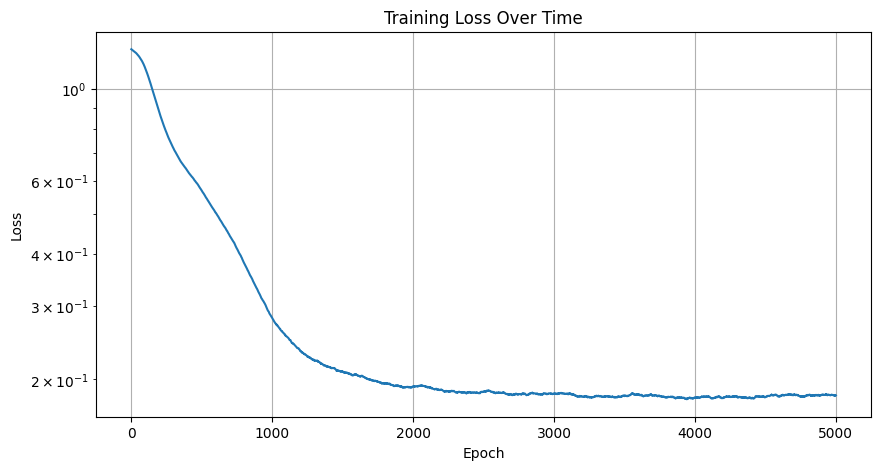

In [ ]:
# Plot the training loss history with logarithmic scaling.
plt.figure(figsize=(10, 5))            # Create figure with wide aspect ratio for clarity
plt.plot(losses)                       # losses: List[float] - historical EMA loss values.
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')                      # Use the log scale to better visualize exponential decay.
plt.grid(True)                         # Add a grid for easier value reading.
plt.show()

## Visualization functions

Here, we can create several utilities for:

- Sample generation;
- Forward/reverse process visualization; and
- Training progress tracking.

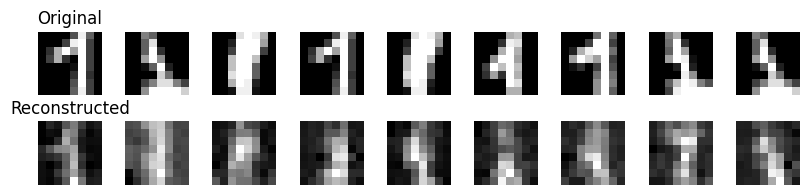

In [ ]:
@partial(nnx.jit, static_argnums=(3,))
def reverse_diffusion_batch(model: UNet,
                          x: jax.Array,
                          key: jax.Array,
                          num_steps: int) -> jax.Array:
    """Efficiently generates samples from the trained diffusion model using batched reverse diffusion (with `jax.lax.scan`).

    Args:
        model (UNet): The trained U-Net model for image generation.
        x (jax.Array): Noisy image (or pure noise).
        key (jax.Array): A JAX PRNG key for generating random noise.
        num_steps (int): Number of denoising steps in the reverse diffusion process.

    Returns:
        jax.Array: The denoised image after `num_steps` iterations.
    """
    # Define the schedule for beta (noise level) and alpha (signal strength).
    beta = jnp.linspace(1e-4, 0.02, num_steps)
    alpha = 1 - beta
    alpha_cumulative = jnp.cumprod(alpha)

    def scan_step(carry: Tuple[jax.Array, jax.Array],
                 step: int) -> Tuple[Tuple[jax.Array, jax.Array], jax.Array]:
        """Applied a single denoising step."""
        # Carry-over information.
        x, key = carry

        # Create a batch of timesteps for the current iteration.
        t_batch = jnp.full((x.shape[0],), step)

        # Predict the noise using the U-Net model.
        predicted = model(x, t_batch)

        # Generate noise for the current timestep (after the first "pure noise" step).
        key, subkey = jax.random.split(key) # Split the JAX PRNG key.
        noise = jnp.where(step > 0, jax.random.normal(subkey, x.shape), 0)

        # Update the image using denoising.
        x_new = 1 / jnp.sqrt(alpha[step]) * (
            x - (1 - alpha[step]) / jnp.sqrt(1 - alpha_cumulative[step]) * predicted
        ) + jnp.sqrt(beta[step]) * noise

        # Return the updated image and carry-over information.
        return (x_new, key), x_new

    steps = jnp.arange(num_steps - 1, -1, -1)
    (final_x, _), _ = jax.lax.scan(scan_step, (x, key), steps)
    return final_x

def plot_samples(model: UNet,
                diffusion: DiffusionModel,
                images: jax.Array,
                key: jax.Array,
                num_samples: int = 9) -> None:
    """Visualize original vs reconstructed images."""
    indices = jax.random.randint(key, (num_samples,), 0, len(images))
    samples = images[indices]

    key, subkey = jax.random.split(key) # Split the JAX PRNG key.
    noisy = diffusion.forward(samples, jnp.full((num_samples,), diffusion.num_steps-1), subkey)[0]

    key, subkey = jax.random.split(key) # Split the JAX PRNG key.
    reconstructed = reverse_diffusion_batch(model, noisy, subkey, diffusion.num_steps)

    fig, axes = plt.subplots(2, num_samples, figsize=(8, 2))

    for i in range(num_samples):
        axes[0, i].imshow(samples[i, ..., 0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i, ..., 0], cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    plt.tight_layout()
    plt.show()

# Create a plot of original vs reconstructed images.
key, subkey = jax.random.split(key) # Split the JAX PRNG key.
plot_samples(model, diffusion, images_test, subkey)


Full Forward and Reverse Process:


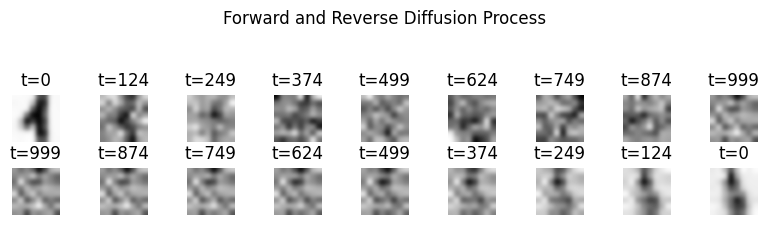

In [ ]:
@partial(nnx.jit, static_argnums=(3,))
def compute_forward_sequence(model: UNet,
                           image: jax.Array,
                           key: jax.Array,
                           num_vis_steps: int) -> jax.Array:
    """Computes the forward diffusion sequence efficiently."""
    # Prepare image sequence and noise parameters.
    image_repeated = jnp.repeat(image[None], num_vis_steps, axis=0)
    timesteps = jnp.linspace(0, 999, num_vis_steps).astype(jnp.int32)  # Assuming 1000 steps
    beta = jnp.linspace(1e-4, 0.02, 1000)
    alpha = 1 - beta
    alpha_cumulative = jnp.cumprod(alpha)

    # Generate and apply noise progressively.
    noise = jax.random.normal(key, image_repeated.shape)
    noisy_images = (
        jnp.sqrt(alpha_cumulative[timesteps])[:, None, None, None] * image_repeated +
        jnp.sqrt(1 - alpha_cumulative[timesteps])[:, None, None, None] * noise
    )
    return noisy_images

@partial(nnx.jit, static_argnums=(3,))
def compute_reverse_sequence(model: UNet,
                           noisy_image: jax.Array,
                           key: jax.Array,
                           num_vis_steps: int) -> jax.Array:
    """Compute reverse diffusion sequence efficiently."""
    # Denoise completely and create interpolation sequence.
    final_image = reverse_diffusion_batch(model, noisy_image[None], key, 1000)[0]
    alphas = jnp.linspace(0, 1, num_vis_steps)
    reverse_sequence = (
        (1 - alphas)[:, None, None, None] * noisy_image +
        alphas[:, None, None, None] * final_image
    )
    return reverse_sequence

def plot_forward_and_reverse(model: UNet,
                          diffusion: DiffusionModel,
                          image: jax.Array,
                          key: jax.Array,
                          num_steps: int = 9) -> None:
    """Plot both forward and reverse diffusion processes with optimized computation."""
    # Compute the forward/reverse transformations
    key1, key2 = jax.random.split(key)
    forward_sequence = compute_forward_sequence(model, image, key1, num_steps)
    reverse_sequence = compute_reverse_sequence(model, forward_sequence[-1], key2, num_steps)

    # Plot the grid.
    fig, (ax1, ax2) = plt.subplots(2, num_steps, figsize=(8, 2))
    fig.suptitle('Forward and reverse diffusion process', y=1.1)

    timesteps = jnp.linspace(0, diffusion.num_steps-1, num_steps).astype(jnp.int32)

    # Visualize forward diffusion.
    for i in range(num_steps):
        ax1[i].imshow(forward_sequence[i, ..., 0], cmap='binary', interpolation='gaussian')
        ax1[i].axis('off')
        ax1[i].set_title(f't={timesteps[i]}')
    ax1[0].set_ylabel('Forward', rotation=90, labelpad=10)

    # Visualize reverse diffusion.
    for i in range(num_steps):
        ax2[i].imshow(reverse_sequence[i, ..., 0], cmap='binary', interpolation='gaussian')
        ax2[i].axis('off')
        ax2[i].set_title(f't={timesteps[num_steps-1-i]}')
    ax2[0].set_ylabel('Reverse', rotation=90, labelpad=10)

    plt.tight_layout()
    plt.show()

# Create a plot.
key, subkey = jax.random.split(key)
print("\nFull forward and reverse diffusion processes:")
plot_forward_and_reverse(model, diffusion, images_test[0], subkey)

## Summary

In this tutorial, we implemented a simple diffusion model using JAX and Flax NNX, and trained it with Optax and Flax NNX. The model consisted of the U-Net model architecture with attention mechanisms, the training used Flax’s NNX JIT compilation (`flax.nnx.jit`), and we also learned how to visualize the diffusion process.